# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [1]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higer_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higer_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higer_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higer_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higer_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 32
sequence_shift = 30
n_features = 39

from collections import defaultdict

E0000 00:00:1732559655.105928  122077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732559655.112231  122077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=train_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
Disas_35, RogueAP_27, (Re)Assoc_32, Deauth_31, Kr00k_55, Evil_Twin_75, (Re)Assoc_35, Krack_25, Kr00k_53, (Re)Assoc_28, Evil_Twin_70, Evil_Twin_62, (Re)Assoc_27, Evil_Twin_54, Evil_Twin_65, Kr00k_56, RogueAP_29, Evil_Twin_50, Disas_37, Kr00k_39, Disas_36, Evil_Twin_33, Kr00k_36, RogueAP_33, RogueAP_39, (Re)Assoc_24, (Re)Assoc_34, Evil_Twin_47, RogueAP_37, Disas_39, (Re)Assoc_25, Deauth_29, Kr00k_43, Kr00k_48, Deauth_32, Evil_Twin_74, Deauth_27, Disas_28, Kr00k_35, Kr00k_51, Deauth_21, Evil_Twin_48, RogueAP_31, Evil_Twin_73, Kr00k_46, Evil_Twin_29, Evil_Twin_72, Evil_Twin_67, Disas_40, Evil_Twin_57, (Re)Assoc_31, Disas_31, Disas_29, RogueAP_28, Evil_Twin_37, Evil_Twin_69, Kr00k_44, Evil_Twin_43, Krack_26, Evil_Twin_41, Deauth_25, Evil_Twin_71, Evil_Twin_40, (Re)Assoc_26, RogueAP_24, Deauth_24, Kr00k_54, Evil_Twin_60, Kr00k_34, RogueAP_26, Evil_Twin_46, Kr00k_40, RogueAP_25, Evil_Twin_30, Evil_Twin_61, Deauth_23, Evil_Twin_63, RogueAP_35, Evil_Twin_53, Evil_Twin_32, Evil_Twi

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

# functions for plotting and confusion matrix

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {100*accuracy:2.3f}%')
    print(f'Precision: {100*precision:2.3f}%')
    print(f'Recall: {100*recall:2.3f}%')
    print(f'F1 : {f1:.4f}')
    print(f'Kappa: {kappa:.4f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(min(min(history['accuracy']), 0.8),1)
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_ylim(min(min(history['precision']), 0.8),1)
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].set_ylim(min(min(history['recall']), 0.8),1)
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [5]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[binary_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Binary CNN-LSTM")
    print(history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
    
bin_cnn_lstm_model.summary()


I0000 00:00:1732559661.983460  122077 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4773 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 32)       │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,581 (2.38 MB)

 Trainable params: 208,193 (813.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,388 (1.59 MB)

I0000 00:00:1732559773.323199  158195 cuda_dnn.cc:529] Loaded cuDNN version 90300


612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy: 99.091%
Precision: 94.089%
Recall: 99.011%
F1 : 0.9649
Kappa: 0.9597


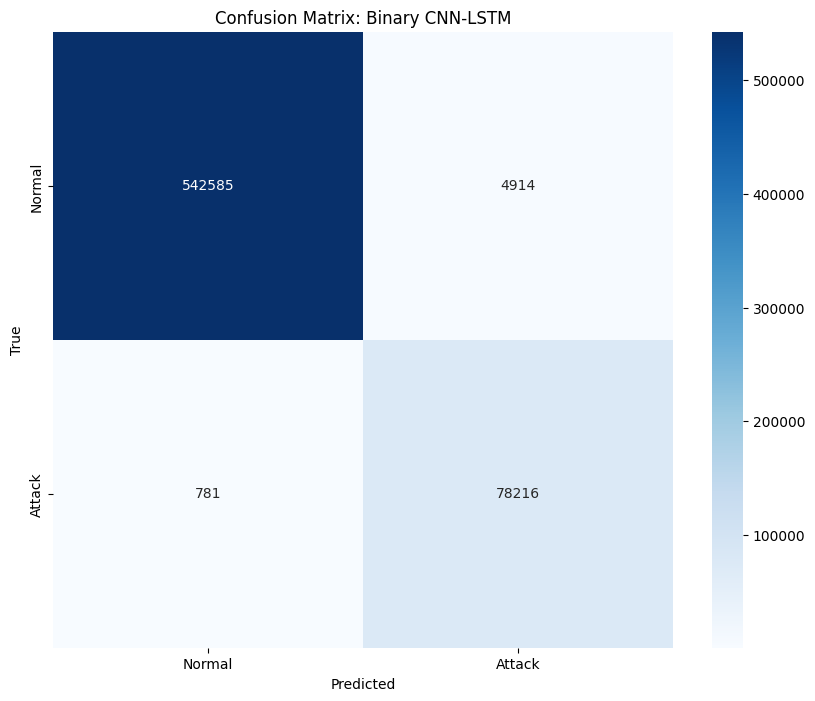

In [6]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


In [7]:
import binary_td_cnn
import data_utils

bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()

if not bin_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[binary_td_cnn.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary Time Domain CNN")
    #loading best checkpoint
    bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()
    
    
bin_cnn_lstm_model.summary()

Model loaded from saved_models/binary_td_cnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 32)       │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,581 (2.38 MB)

 Trainable params: 208,193 (813.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,388 (1.59 MB)

612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Accuracy: 99.286%
Precision: 96.168%
Recall: 98.256%
F1 : 0.9720
Kappa: 0.9679


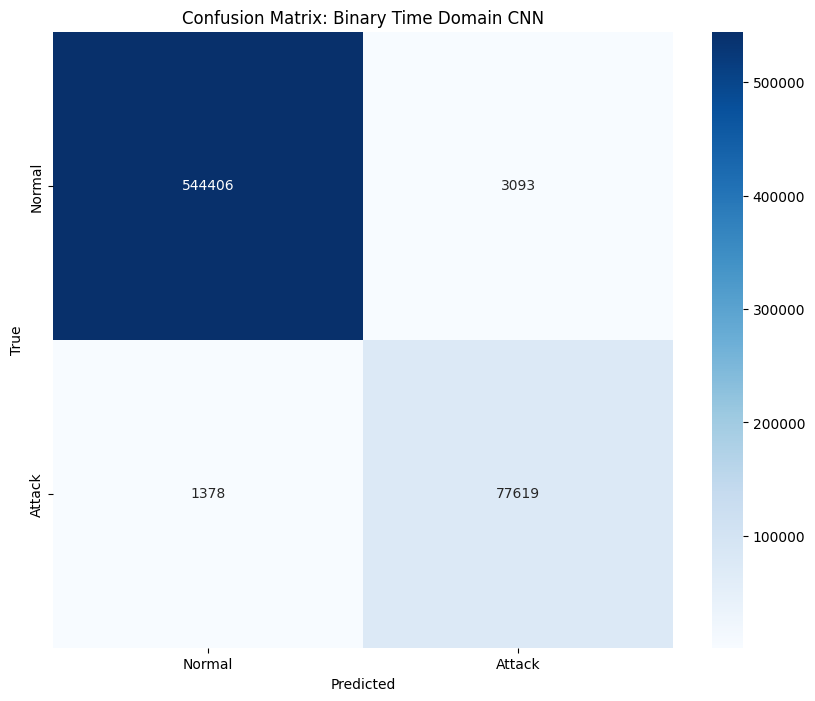

In [8]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_td_cnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary Time Domain CNN")


In [9]:
import binary_cnn_gru_lite
import data_utils

bin_cnn_gru_model = binary_cnn_gru_lite.binary_CNN_GRU_lite_model()

if not bin_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[bin_cnn_gru_model.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary CNN")
    #loading best checkpoint
    bin_cnn_gru_model = binary_cnn_gru_lite.binary_CNN_GRU_lite_model()
    
    
bin_cnn_gru_model.summary()

Model loaded from saved_models/binary_cnn_gru_lite.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 40)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 32)       │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,213 (102.40 KB)

 Trainable params: 8,737 (34.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,476 (68.27 KB)

612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 99.415%
Precision: 95.922%
Recall: 99.591%
F1 : 0.9772
Kappa: 0.9739


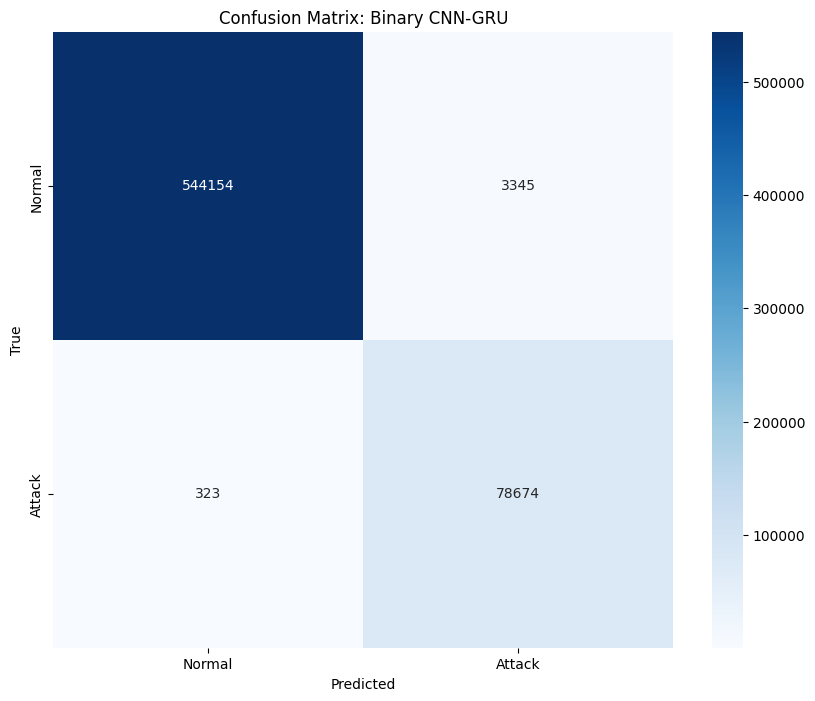

In [10]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_gru_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-GRU")


In [11]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Binary 1D-CNN')

bin_cnn1d_model.summary()




Model loaded from saved_models/binary_cnn1d.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 30)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,396 (21.08 KB)

 Trainable params: 2,613 (10.21 KB)

 Non-trainable params: 168 (672.00 B)

 Optimizer params: 2,615 (10.22 KB)

I0000 00:00:1732560138.996501  158198 service.cc:148] XLA service 0x55cce1c1c880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732560138.996522  158198 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1


   87/19578 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step    

I0000 00:00:1732560139.405431  158198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19578/19578 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
Accuracy: 99.615%
Precision: 97.194%
Recall: 99.829%
F1 : 0.9849
Kappa: 0.9827


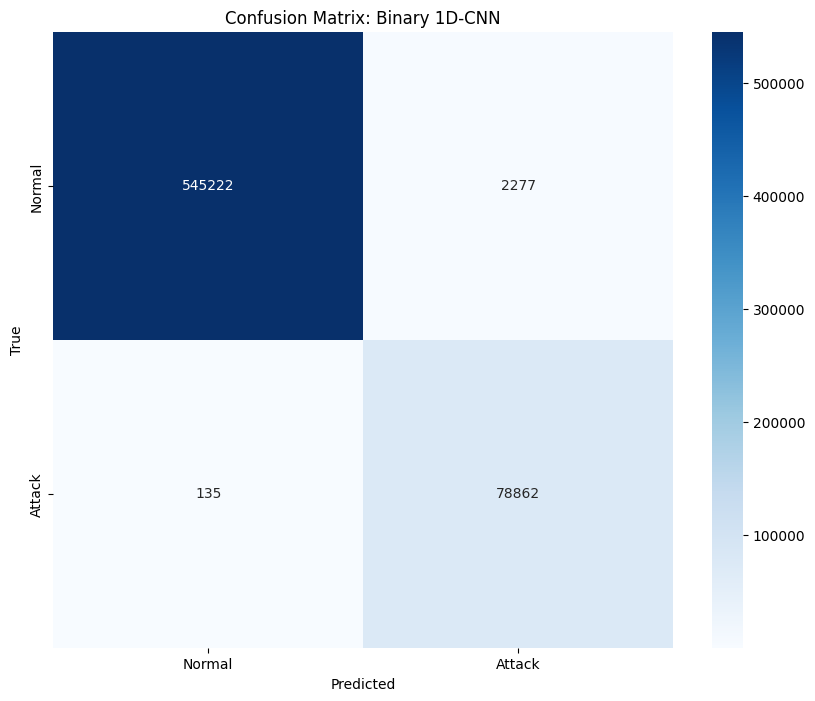

In [12]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


In [13]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    bin_dnn_model.summary()
    plot_model_history(history.history, 'Binary MLP')

     

Model loaded from saved_models/binary_dnn.keras


19578/19578 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
Accuracy: 99.583%
Precision: 96.917%
Recall: 99.871%
F1 : 0.9837
Kappa: 0.9813


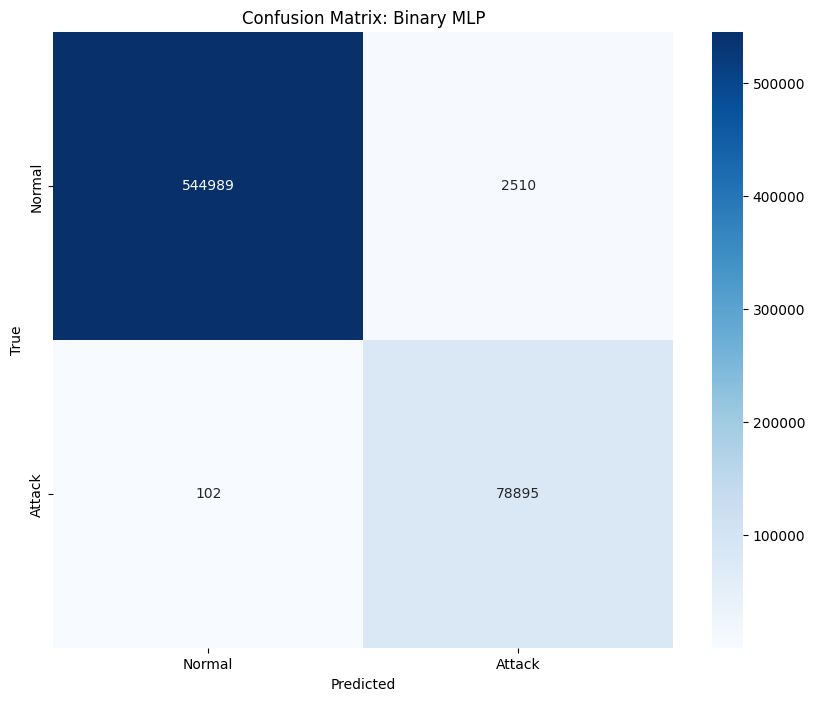

In [14]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_dnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary MLP')

## Results:

* CNN-LSTM
    * Accuracy: 99.091%
    * Precision: 94.089%
    * Recall: 99.011%
    * F1 : 0.9649
    * Kappa: 0.9597
* Time Domain CNN:
    * Accuracy: 99.286%
    * Precision: 96.168%
    * Recall: 98.256%
    * F1 : 0.9720
    * Kappa: 0.9679
* CNN-GRU
    * Accuracy: 99.415%
    * Precision: 95.922%
    * Recall: 99.591%
    * F1 : 0.9772
    * Kappa: 0.9739
* 1D-CNN
    * Accuracy: 99.615%
    * Precision: 97.194%
    * Recall: 99.829%
    * F1 : 0.9849
    * Kappa: 0.9827
* MLP
    * Accuracy: 99.583%
    * Precision: 96.917%
    * Recall: 99.871%
    * F1 : 0.9837
    * Kappa: 0.9813



In [15]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate1.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 1)   │     41,121 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │      2,781 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 1)   │      2,781 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 1)   │          0 │ sequential[0][0], │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,683 (182.36 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 46,683 (182.36 KB)

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_arithmentic_mean_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean, Time Domain CNN, 1D-CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print('F1 calculated_weights')
print(bin_f1_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate1 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate1.summary()

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_f1_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 score wheighted mean, Time Domain CNN, 1D-CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print('Kappa score calculated weights')
print(bin_kappa_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate1.summary()

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
kappa_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Cohen Kappa score wheighted mean, Time Distributed CNN, 1D-CNN, MLP')

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape
input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)
reshaped_bin_td_cnn = Reshape((None, 1))(bin_td_cnn_model(input))
bin_base_classifiers = [
    reshaped_bin_td_cnn,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [
    reshaped_bin_td_cnn,
    td_bin_cnn1d_model(input),
    td_bin_dnn_model(input)
]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor1.summary()

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_log_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-LSTM, CNN1D, MLP')

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression, CNN-LSTM, 1D-CNN, MLP')

In [ ]:
output_layer = bin_stacked_log_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor1.summary()

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_kappa_weighted_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked weighted logistic regressor, CNN-LSTM, CNN1D, MLP')

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier1.summary()

In [ ]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked MLP classifier, CNN-LSTM, CNN1D, MLP')

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP, CNN-LSTM, 1D-CNN, MLP')

----------------------------------------------------------

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    bin_cnn_gru_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate2.summary()

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    bin_cnn_gru_model,
    td_bin_dnn_model,
]

bin_f1_weights = [
    bin_td_cnn_metrics[3],
    bin_cnb_gru_metrics[3],
    bin_dnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate2 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate2.summary()

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 score wheighted mean, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    bin_cnn_gru_model,
    td_bin_dnn_model,
]

bin_kappa_weights = [
    bin_td_cnn_metrics[4],
    bin_cnb_gru_metrics[4],
    bin_dnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate2.summary()

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Cohen Kappa score wheighted mean, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate
input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_td_cnn_model,
    bin_cnn_gru_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor2.summary()

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_log_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Logistic Regression, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor2.summary()

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_kappa_weighted_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Logistic Regression, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier2.summary()

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-GRU, Time Domain CNN, MLP')

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP, CNN-GRU, Time Domain CNN, MLP')

----------------------------------------------------------------------

In [ ]:
import multiclass_cnn_lstm
import data_utils

mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()

if not mul_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-LSTM")
    print(history)
    #loading best checkpoint
    mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()
    
    
mul_cnn_lstm_model.summary()


In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.math.argmax(labels, axis=-1)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = tf.math.argmax(y_pred, axus=-1)
y_true = labels.numpy().flatten()
    
mul_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-LSTM", binary=False)


In [ ]:
import multiclass_cnn_gru_lite
import data_utils

mul_cnn_gru_model = multiclass_cnn_gru_lite.multiclass_CNN_GRU_lite_model()

if not mul_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_gru_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_gru_lite.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-GRU")
    print(history)
    #loading best checkpoint
    mul_cnn_gru_model = multiclass_cnn_gru_lite.multiclass_CNN_GRU_lite_model()
    
    
mul_cnn_gru_model.summary()


In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.math.argmax(labels, axis=-1)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = tf.math.argmax(y_pred, axus=-1)
y_true = labels.numpy().flatten()
    
mul_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False)

In [ ]:
import multiclass_td_cnn
import data_utils

mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()

if not mul_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_td_cnn_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_td_cnn.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass Time-Domain CNN")
    print(history)
    #loading best checkpoint
    mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()
    
    
mul_td_cnn_model.summary()


In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.math.argmax(labels, axis=-1)
labels = tf.concat(labels, axis=0)

y_pred = mul_td_cnn_model.predict(features)
y_pred = tf.math.argmax(y_pred, axus=-1)
y_true = labels.numpy().flatten()
    
mul_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False)

In [ ]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = mul_cnn1d_model.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.math.argmax(labels, axis=-1)
labels = tf.concat(labels, axis=0)

y_pred = mul_cnn1d_model.predict(features)
y_pred = tf.math.argmax(y_pred, axus=-1)
y_true = labels.numpy().flatten()
    
mul_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False)

In [ ]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = mul_cnn1d_model.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



### Results

In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda

input_shape = (None, n_features)
input = Input(input_shape)

mul_bin_cnn1d_model = TimeDistributed(mul_cnn1d_model)
mul_bin_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_cnn1d_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Lambda(lambda x: tf.math.reduce_mean(x, axis=-2))(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate1.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)
    
features = tf.concat(features, axis=0)
labels = tf.math.argmax(labels, axis=-1)
labels = tf.concat(labels, axis=0)

y_pred = mul_arithmetic_mean_aggregate1.predict(features)
y_pred = tf.math.argmax(y_pred, axus=-1)
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Multiclass stacked classifier, F1 score wheighted mean, CNN-GRU, Time Domain CNN, MLP')